<a href="https://colab.research.google.com/github/Stefi96/DetectingNFTs-Master/blob/main/Images_NFTs_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Bidirectional
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import KFold
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.layers import Input, Concatenate

In [2]:
# Paths to  scam and legit images on Google Drive
scam_dir = "/content/drive/MyDrive/Master/Project/Images/Images_scam"
legit_dir = "/content/drive/MyDrive/Master/Project/Images/Images_legit"

# List the images in the directories
scam_images = os.listdir(scam_dir)
legit_images = os.listdir(legit_dir)

# Print the number of images detected in each directory
print(f"Number of scam images detected: {len(scam_images)}")
print(f"Number of legit images detected: {len(legit_images)}")

Number of scam images detected: 1082
Number of legit images detected: 1762


In [3]:
# Paths to all the scam and legit images
# NOTE: One option is the paths for google cloud and the other for running locally
scam_image_paths = [os.path.join(scam_dir, image) for image in os.listdir(scam_dir)]
legit_image_paths = [os.path.join(legit_dir, image) for image in os.listdir(legit_dir)]
#scam_image_paths = [os.path.join(r"C:\Users\stefanve\Desktop\Project\Images\Images_scam", image) for image in os.listdir(r"C:\Users\stefanve\Desktop\Project\Images\Images_scam")]
#legit_image_paths = [os.path.join(r"C:\Users\stefanve\Desktop\Project\Images\Images_legit", image) for image in os.listdir(r"C:\Users\stefanve\Desktop\Project\Images\Images_legit")]

In [4]:
# def try_loading_images(image_paths):
#     loaded_images = []
#     for img_path in image_paths[:10]:  # Limiting to the first 10 images for testing
#         try:
#             img = Image.open(img_path).resize((128, 128))
#             img_array = np.array(img) / 255.0
#             loaded_images.append(img_array)
#         except Exception as e:
#             print(f"Error with image {img_path}: {e}")
#     return loaded_images

# # Attempt to load and process a subset of scam and legit images
# loaded_scam_images = try_loading_images(scam_image_paths)
# loaded_legit_images = try_loading_images(legit_image_paths)

# print(f"Number of scam images loaded: {len(loaded_scam_images)}")
# print(f"Number of legit images loaded: {len(loaded_legit_images)}")

In [5]:
def load_and_preprocess_images(image_paths, label):
    data = []
    labels = []
    for img_path in image_paths:
        try:
            # Open the image and convert to RGB (removing any alpha channel)
            img = Image.open(img_path).convert("RGB").resize((128, 128))
            img_array = np.array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error with image {img_path}: {e}")
    return data, labels

In [6]:
# Load and preprocess the images using the modified function
scam_data, scam_labels = load_and_preprocess_images(scam_image_paths, "scam")
legit_data, legit_labels = load_and_preprocess_images(legit_image_paths, "legit")

# Combine data and labels
all_data = scam_data + legit_data
all_labels = scam_labels + legit_labels

print(f"Total number of images in all_data: {len(all_data)}")
print(f"Total number of labels in all_labels: {len(all_labels)}")

Total number of images in all_data: 2844
Total number of labels in all_labels: 2844


In [7]:
all_data = scam_data + legit_data
all_labels = scam_labels + legit_labels

print(f"Total number of images in all_data: {len(all_data)}")
print(f"Total number of labels in all_labels: {len(all_labels)}")

Total number of images in all_data: 2844
Total number of labels in all_labels: 2844


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(all_data, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training data size: {len(X_train)}")
print(f"Validation data size: {len(X_val)}")
print(f"Test data size: {len(X_test)}")

Training data size: 1990
Validation data size: 427
Test data size: 427


In [9]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)


In [10]:
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

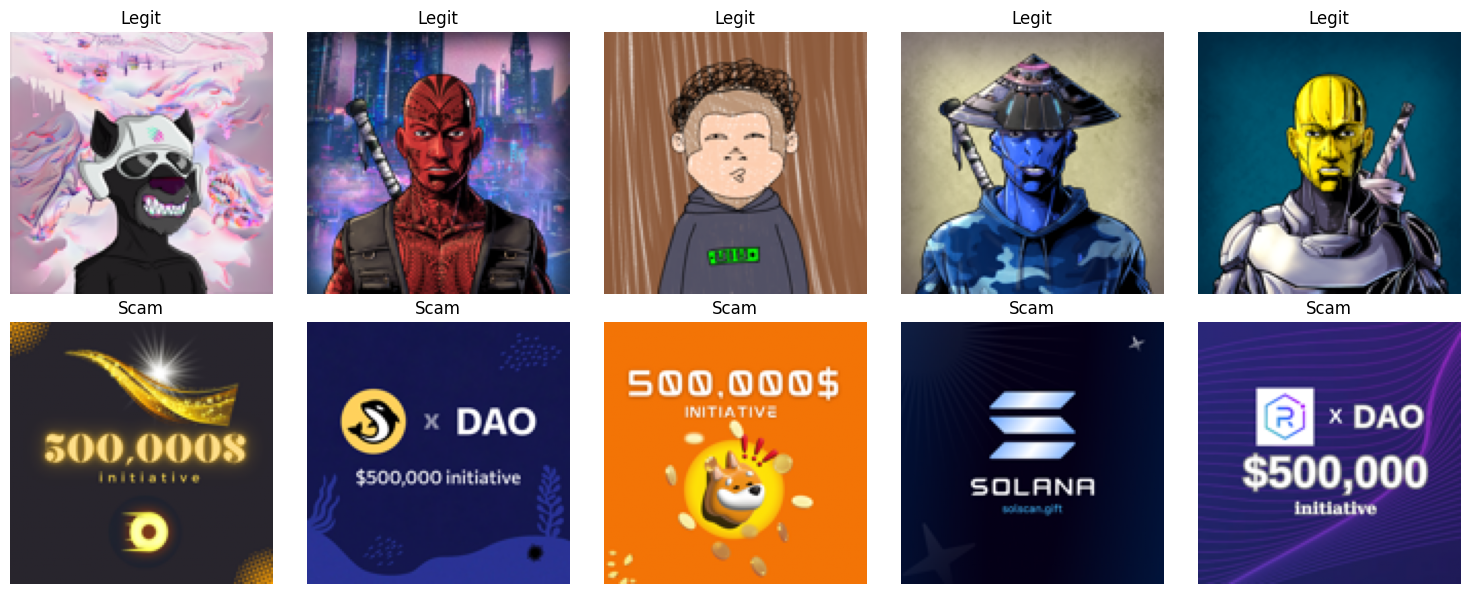

In [11]:
# Define a function to display sample images from each class
def display_sample_images(X, y, label_mapping, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for label, label_str in label_mapping.items():
        # Get indices of images belonging to the current label
        indices = np.where(y == label)[0]

        # Randomly select 'num_samples' indices
        selected_indices = np.random.choice(indices, num_samples, replace=False)

        for idx, ax in enumerate(axes[label]):
            ax.imshow(X[selected_indices[idx]])
            ax.set_title(label_str)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Convert one-hot encoded labels back to integer labels for easier indexing
y_train_int = np.argmax(y_train, axis=1)

# Define the label mapping based on the y_train data
label_mapping = {0: 'Legit', 1: 'Scam'}

# Display sample images
display_sample_images(X_train, y_train_int, label_mapping)

In [12]:
input_shape = (128, 128, 3)

# Adding dropout layers
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [15]:
# Implementing data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [16]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1990, 128, 128, 3)
y_train shape: (1990, 2)
X_val shape: (427, 128, 128, 3)
y_val shape: (427, 2)


In [18]:
number_of_epochs = 50  # Adjust this based on your requirements
history = model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=number_of_epochs,
                    callbacks=[early_stop])

Epoch 1/50
63/63 [==============================] - 22s 165ms/step - loss: 0.6746 - accuracy: 0.7678 - val_loss: 0.3096 - val_accuracy: 0.8899
Epoch 2/50
63/63 [==============================] - 8s 127ms/step - loss: 0.2320 - accuracy: 0.9256 - val_loss: 0.2100 - val_accuracy: 0.9461
Epoch 3/50
63/63 [==============================] - 8s 122ms/step - loss: 0.1933 - accuracy: 0.9407 - val_loss: 0.2301 - val_accuracy: 0.9508
Epoch 4/50
63/63 [==============================] - 10s 159ms/step - loss: 0.1672 - accuracy: 0.9508 - val_loss: 0.1969 - val_accuracy: 0.9602
Epoch 5/50
63/63 [==============================] - 9s 139ms/step - loss: 0.1528 - accuracy: 0.9543 - val_loss: 0.1405 - val_accuracy: 0.9555
Epoch 6/50
63/63 [==============================] - 8s 125ms/step - loss: 0.1270 - accuracy: 0.9623 - val_loss: 0.1321 - val_accuracy: 0.9555
Epoch 7/50
63/63 [==============================] - 10s 156ms/step - loss: 0.1073 - accuracy: 0.9653 - val_loss: 0.1484 - val_accuracy: 0.9555
Epo

In [19]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))
print(f"Test accuracy: {test_acc}")

14/14 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9859
Test accuracy: 0.9859485030174255


In [20]:
print(f"Original X_test shape: {np.array(X_test).shape}")

# Reshape if necessary
X_test_reshaped = np.array(X_test).reshape(-1, 128, 128, 3)  # Assuming your images are 128x128 and RGB
print(f"Reshaped X_test shape: {X_test_reshaped.shape}")

Original X_test shape: (427, 128, 128, 3)
Reshaped X_test shape: (427, 128, 128, 3)


In [21]:
# Predict the labels for the test set using reshaped data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_classes)
print(f"\nROC-AUC: {roc_auc:.4f}")


14/14 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       265
           1       1.00      0.96      0.98       162

    accuracy                           0.99       427
   macro avg       0.99      0.98      0.98       427
weighted avg       0.99      0.99      0.99       427


Confusion Matrix:
[[265   0]
 [  6 156]]

ROC-AUC: 0.9815


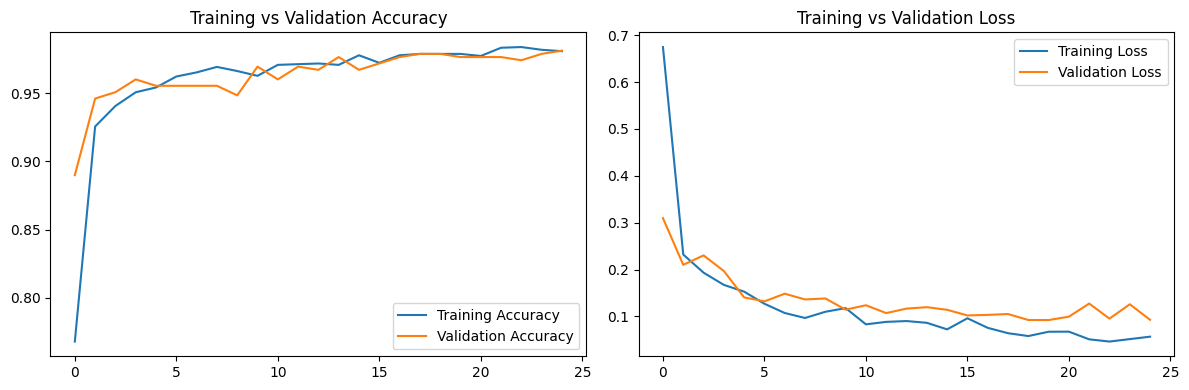

In [22]:
# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()

In [23]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(2, activation='softmax')(x)  # Final classification layer

model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# only for collab
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [29]:
# # only for collab
# from keras.utils import to_categorical

# # Map the string labels to integers
# label_mapping = {"scam": 0, "legit": 1}

# y_train_int = np.array([label_mapping[label] for label in y_train])
# y_val_int = np.array([label_mapping[label] for label in y_val])

# # Now apply one-hot encoding
# y_train = to_categorical(y_train_int, num_classes=2)
# y_val = to_categorical(y_val_int, num_classes=2)

In [30]:
# only for collab
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(1990, 128, 128, 3)
(1990, 2)
(427, 128, 128, 3)
(427, 2)


In [31]:
# Define early stopping, if necesarry patience can be 15
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train using data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)

Epoch 1/10
63/63 [==============================] - 15s 156ms/step - loss: 0.8760 - accuracy: 0.6156 - val_loss: 0.7446 - val_accuracy: 0.6183
Epoch 2/10
63/63 [==============================] - 10s 164ms/step - loss: 0.7801 - accuracy: 0.5844 - val_loss: 0.6690 - val_accuracy: 0.6183
Epoch 3/10
63/63 [==============================] - 10s 166ms/step - loss: 0.7423 - accuracy: 0.5658 - val_loss: 0.6410 - val_accuracy: 0.6183
Epoch 4/10
63/63 [==============================] - 8s 131ms/step - loss: 0.7014 - accuracy: 0.5734 - val_loss: 0.6289 - val_accuracy: 0.6183
Epoch 5/10
63/63 [==============================] - 10s 164ms/step - loss: 0.6927 - accuracy: 0.5789 - val_loss: 0.6195 - val_accuracy: 0.6183
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.6685 - accuracy: 0.5829 - val_loss: 0.6108 - val_accuracy: 0.6183
Epoch 7/10
63/63 [==============================] - 8s 131ms/step - loss: 0.6478 - accuracy: 0.6236 - val_loss: 0.6024 - val_accuracy: 0.6183
E

In [32]:
# Fine-tuning: Unfreeze the last 4 layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [33]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with a lower learning rate
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val),
                         epochs=50)

Epoch 1/50
63/63 [==============================] - 15s 182ms/step - loss: 0.4216 - accuracy: 0.8503 - val_loss: 0.5546 - val_accuracy: 0.7635
Epoch 2/50
63/63 [==============================] - 8s 131ms/step - loss: 0.3366 - accuracy: 0.8799 - val_loss: 0.5199 - val_accuracy: 0.8244
Epoch 3/50
63/63 [==============================] - 10s 164ms/step - loss: 0.3011 - accuracy: 0.9035 - val_loss: 0.4663 - val_accuracy: 0.8525
Epoch 4/50
63/63 [==============================] - 10s 166ms/step - loss: 0.2756 - accuracy: 0.9090 - val_loss: 0.3992 - val_accuracy: 0.8665
Epoch 5/50
63/63 [==============================] - 8s 133ms/step - loss: 0.2639 - accuracy: 0.9161 - val_loss: 0.3418 - val_accuracy: 0.8618
Epoch 6/50
63/63 [==============================] - 11s 169ms/step - loss: 0.2533 - accuracy: 0.9231 - val_loss: 0.2980 - val_accuracy: 0.9133
Epoch 7/50
63/63 [==============================] - 11s 168ms/step - loss: 0.2469 - accuracy: 0.9161 - val_loss: 0.2733 - val_accuracy: 0.9133
E

In [34]:
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))
print(f"Test accuracy: {test_acc}")

14/14 [==============================] - 0s 19ms/step - loss: 0.1349 - accuracy: 0.9508
Test accuracy: 0.9508196711540222


In [35]:
# Predict the labels for the test set using reshaped data
X_test = np.array(X_test)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# ROC-AUC
# Note: This is for binary classification. If your task is multi-class, this will need adjustments.
roc_auc = roc_auc_score(y_true, y_pred_classes)
print(f"\nROC-AUC: {roc_auc:.4f}")

14/14 [==============================] - 1s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       265
           1       0.94      0.93      0.93       162

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427


Confusion Matrix:
[[255  10]
 [ 11 151]]

ROC-AUC: 0.9472


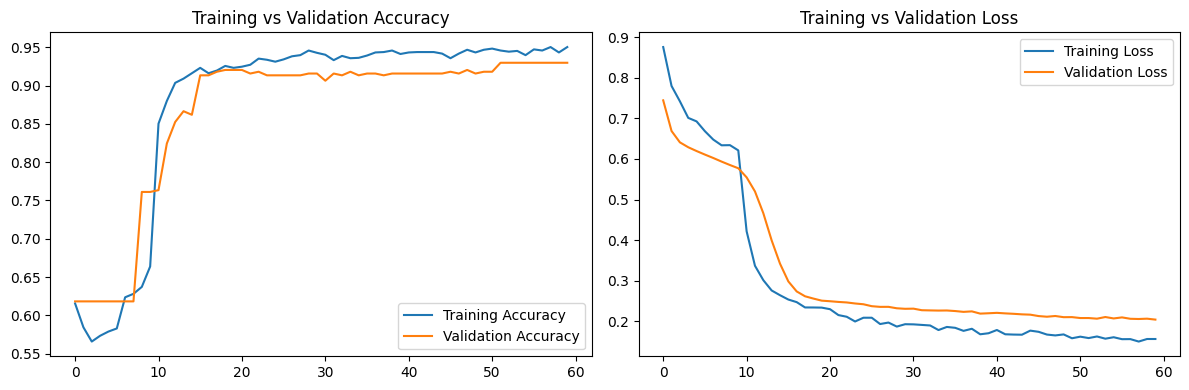

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()

In [37]:
# Reshape the data to match the expected input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], 128, 128 * 3)
X_val_reshaped = X_val.reshape(X_val.shape[0], 128, 128 * 3)

# Define the RNN model
model = Sequential()

# Add Bidirectional LSTM layers with increased units
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(128, 128 * 3)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, activation='tanh')))
model.add(Dropout(0.5))

# Classification layer
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Define early stopping and learning rate reduction on plateau
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
63/63 [==============================] - 13s 58ms/step - loss: 0.2776 - accuracy: 0.8905 - val_loss: 0.1807 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 2s 33ms/step - loss: 0.1661 - accuracy: 0.9513 - val_loss: 0.1913 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 2s 31ms/step - loss: 0.1439 - accuracy: 0.9533 - val_loss: 0.1739 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 2s 36ms/step - loss: 0.1384 - accuracy: 0.9603 - val_loss: 0.2027 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 3s 41ms/step - loss: 0.1459 - accuracy: 0.9548 - val_loss: 0.1412 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - 2s 32ms/step - loss: 0.1207 - accuracy: 0.9618 - val_loss: 0.1555 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 7/50
63/63 [==============================] - 2s 32ms/step - loss: 0.

In [38]:
X_test = np.array(X_test)
X_test_reshaped = X_test.reshape(X_test.shape[0], 128, 128 * 3)
y_test = np.array(y_test)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test_reshaped: (427, 128, 384)
Shape of y_test: (427, 2)


In [39]:
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"Test accuracy: {test_acc}")

14/14 [==============================] - 0s 19ms/step - loss: 0.0610 - accuracy: 0.9836
Test accuracy: 0.9836065769195557


In [40]:
# Predict the labels for the test set using reshaped data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# ROC-AUC
# Note: This is for binary classification. If your task is multi-class, this will need adjustments.
roc_auc = roc_auc_score(y_true, y_pred_classes)
print(f"\nROC-AUC: {roc_auc:.4f}")

14/14 [==============================] - 3s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       265
           1       0.99      0.97      0.98       162

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427


Confusion Matrix:
[[263   2]
 [  5 157]]

ROC-AUC: 0.9808


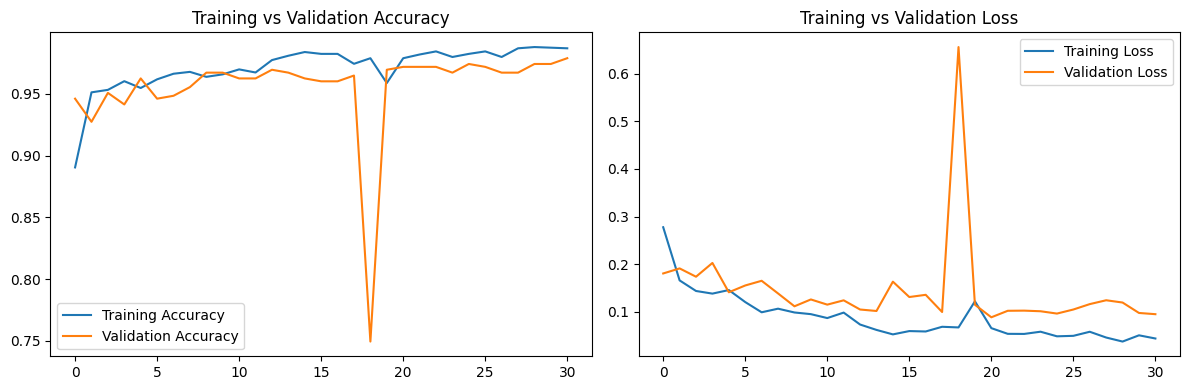

In [41]:
# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()

In [42]:
# Load VGG16 without top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation (optional but recommended for small datasets)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Train the model using augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)


Epoch 1/10
63/63 [==============================] - 13s 179ms/step - loss: 0.7832 - accuracy: 0.5990 - val_loss: 0.6658 - val_accuracy: 0.6183
Epoch 2/10
63/63 [==============================] - 8s 130ms/step - loss: 0.6683 - accuracy: 0.6367 - val_loss: 0.5761 - val_accuracy: 0.6159
Epoch 3/10
63/63 [==============================] - 10s 162ms/step - loss: 0.5805 - accuracy: 0.6884 - val_loss: 0.5110 - val_accuracy: 0.7190
Epoch 4/10
63/63 [==============================] - 10s 160ms/step - loss: 0.5300 - accuracy: 0.7151 - val_loss: 0.4567 - val_accuracy: 0.8782
Epoch 5/10
63/63 [==============================] - 8s 129ms/step - loss: 0.4627 - accuracy: 0.7970 - val_loss: 0.4129 - val_accuracy: 0.9321
Epoch 6/10
63/63 [==============================] - 10s 164ms/step - loss: 0.4211 - accuracy: 0.8422 - val_loss: 0.3761 - val_accuracy: 0.9438
Epoch 7/10
63/63 [==============================] - 10s 152ms/step - loss: 0.3894 - accuracy: 0.8709 - val_loss: 0.3456 - val_accuracy: 0.9485
E

In [43]:
X_test = preprocess_input(X_test)

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

14/14 [==============================] - 0s 16ms/step - loss: 1.6803 - accuracy: 0.3794
Test accuracy: 0.3793911039829254


In [45]:
# ResNet for initial feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers for transfer learning

x = base_model.output

# Custom CNN for further feature extraction
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

# Classification layer
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)  # Assuming binary classification

model = Model(inputs=base_model.input, outputs=outputs)


In [46]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define some constants
num_epochs = 10
batch_size = 32

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=num_epochs,
                    batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# ROC-AUC (assuming binary classification)
roc_auc = roc_auc_score(y_true, y_pred_classes)
print(f"\nROC-AUC: {roc_auc:.4f}")


Epoch 1/10
63/63 [==============================] - 8s 56ms/step - loss: 0.2526 - accuracy: 0.9015 - val_loss: 0.1987 - val_accuracy: 0.9251
Epoch 2/10
63/63 [==============================] - 2s 28ms/step - loss: 0.1239 - accuracy: 0.9558 - val_loss: 0.1616 - val_accuracy: 0.9485
Epoch 3/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0992 - accuracy: 0.9683 - val_loss: 0.1436 - val_accuracy: 0.9508
Epoch 4/10
63/63 [==============================] - 2s 25ms/step - loss: 0.0800 - accuracy: 0.9739 - val_loss: 0.1620 - val_accuracy: 0.9532
Epoch 5/10
63/63 [==============================] - 2s 24ms/step - loss: 0.0624 - accuracy: 0.9799 - val_loss: 0.1364 - val_accuracy: 0.9649
Epoch 6/10
63/63 [==============================] - 2s 25ms/step - loss: 0.0602 - accuracy: 0.9779 - val_loss: 0.1599 - val_accuracy: 0.9555
Epoch 7/10
63/63 [==============================] - 1s 24ms/step - loss: 0.0575 - accuracy: 0.9784 - val_loss: 0.1882 - val_accuracy: 0.9532
Epoch 8/10
63